In [8]:
import pyodbc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.gcf().subplots_adjust(bottom=-0.5) # doesn't work

<Figure size 432x288 with 0 Axes>

In [2]:
def initialize():
    '''Establish connection with our soccer DB.
    Output: cnxn, cursor (globally for convenience)'''

    server = 'imt563a.database.windows.net'
    database = 'IMT563'
    username = 'richardm'
    password = 'please_work_123'
    driver= '{SQL Server}'
    global cnxn, cursor
    cnxn = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)
    cursor = cnxn.cursor()

# All these functions first call initialize, then close connection and cursor
def output_rows(cursor):
    '''Print output from SELECT'''
    row = cursor.fetchone()
    while row:
        print(row)
        row = cursor.fetchone()
def get_constraints(table='Player_new_PK_SI'):
    initialize()
    sql = '''
    SELECT OBJECT_NAME(object_id) AS ConstraintName,
        OBJECT_NAME(parent_object_id) AS TableName,
        type_desc AS ConstraintType
    FROM sys.objects
    WHERE type_desc LIKE '%CONSTRAINT' AND OBJECT_NAME(parent_object_id) = \'''' + table_name + '''\'
    '''
    cursor.execute(sql)
    output_rows(cursor)
    cursor.close()
    cnxn.close()
def close():
    global cursor, cnxn
    cursor.close()
    cnxn.close()

In [3]:
initialize()

### BULK INSERT Experiment with Player Table
Get average time-taken for each batch size of BULK INSERTS on the Player table (as dictionary)

In [13]:
## Bulk insert experiment -- return batch_avg dict
batches = [1, 5, 10, 20, 50, 100, 500, 1000, 2500, 6000, 10000, 11060] # Try with [11060] for quick test
def bulk_insert_experiment(table_name, sql_stmt):
    initialize()
    print("----\nRunning batches for", table_name)
    # Keep track of each batch-time to compute averages
    batch_times = {batch:[] for batch in batches}

    for i in range(5):
        # Pause to let our DTU's catch up
        time.sleep(5) # doesn't seem to be doing anything
        for batch_size in batches:
            cursor.execute('''TRUNCATE TABLE ''' + table_name)
            cursor.commit()
            #print(batch_size)

            start = time.time()

            first_row = 2
            last_row = 2 + batch_size - 1

            # BULK INSERT <batch_size> rows from csv
            sql = sql_stmt.format(table_name, first_row, last_row)
            cursor.execute(sql)

            cursor.commit()
            end = time.time()
            total_time = end - start
            # Record time and append it to dict
            #print(total_time, "seconds")
            batch_times[batch_size].append(total_time)

    # Output averages
    batch_avg = {}
    print("** AVERAGES **")
    for batch in batches:
        times = batch_times[batch]
        print("Batch:", batch, "Avg:", sum(times)/len(times))
        batch_avg[batch] = sum(times)/len(times)
        
    # Close cursor and connection
    close()
    return batch_avg

In [14]:
t1 = time.time()
sql_stmt = '''
        BULK INSERT {}
        FROM 'Player.csv'
        WITH ( DATA_SOURCE = 'imt563ian_blobdatasource', FORMAT='CSV', FIRSTROW={}, LASTROW={});'''
A = bulk_insert_experiment("Player_new_No_Constraint", sql_stmt)
B = bulk_insert_experiment("Player_new_PK", sql_stmt)
C = bulk_insert_experiment("Player_new_PK_SI", sql_stmt)
print("Time taken", time.time() - t1)

----
Running batches for Player_new_No_Constraint
** AVERAGES **
Batch: 1 Avg: 0.43114304542541504
Batch: 5 Avg: 0.36504926681518557
Batch: 10 Avg: 0.3550106048583984
Batch: 20 Avg: 0.333685302734375
Batch: 50 Avg: 0.35270466804504397
Batch: 100 Avg: 0.3421631813049316
Batch: 500 Avg: 0.3687741279602051
Batch: 1000 Avg: 0.33364248275756836
Batch: 2500 Avg: 0.4051381587982178
Batch: 6000 Avg: 0.6624069690704346
Batch: 10000 Avg: 1.5832300186157227
Batch: 11060 Avg: 1.9114573001861572
----
Running batches for Player_new_PK
** AVERAGES **
Batch: 1 Avg: 0.3503002643585205
Batch: 5 Avg: 0.33211002349853513
Batch: 10 Avg: 0.32664804458618163
Batch: 20 Avg: 0.33842968940734863
Batch: 50 Avg: 0.3333582401275635
Batch: 100 Avg: 0.3392296314239502
Batch: 500 Avg: 0.3385298728942871
Batch: 1000 Avg: 0.3646674633026123
Batch: 2500 Avg: 0.34212536811828614
Batch: 6000 Avg: 0.6054218292236329
Batch: 10000 Avg: 1.8253232479095458
Batch: 11060 Avg: 1.9477821826934814
----
Running batches for Player_ne

## Plotting

In [16]:
df = pd.DataFrame({'none':A, 'PK':B, 'PK & Index':C})
# Drop last row of baselines
df

,none,PK,PK & Index
1,0.431143,0.350300,0.452785
5,0.365049,0.332110,0.333854
10,0.355011,0.326648,0.329347
20,0.333685,0.338430,0.338187
50,0.352705,0.333358,0.335221
100,0.342163,0.339230,0.340470
500,0.368774,0.338530,0.365782
1000,0.333642,0.364667,0.360329
2500,0.405138,0.342125,0.690416
6000,0.662407,0.605422,2.495271


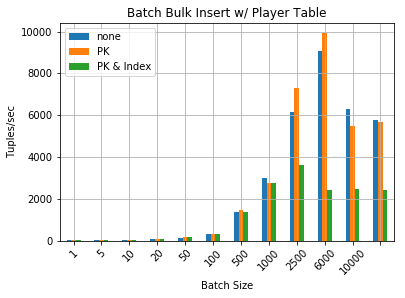

In [18]:
df = pd.DataFrame({'none':A, 'PK':B, 'PK & Index':C})
# Drop last row of baselines

df = df.apply(lambda x: x.index/x)

ax = df.plot(kind='bar', grid=True)
_=ax.set_title("Batch Bulk Insert w/ Player Table")
_=ax.set_ylabel("Tuples/sec")
_=ax.set_xlabel("Batch Size")
_=ax.set_xticklabels(batches[:-1], rotation=45)

# 9B 
### Re-run BULK INSERT on Match Table with 1, 2, 3, and 4 non-clustered indexes (this is in addition to the clustered primary key

### Modified BULK INSERT code

In [25]:
def bulk_insert_INDEXES_experiment(table_name, sql_stmt):
    initialize()
    print("----\nRunning batches for", table_name)
    # Keep track of each batch-time but don't compute averages this time
    batch_times = {batch:[] for batch in batches}

    cursor.execute('''TRUNCATE TABLE ''' + table_name)
    cursor.commit()

    start = time.time()

    batch_size = 10000
    first_row = 2
    last_row = 2 + batch_size - 1

    # BULK INSERT <batch_size> rows from csv
    sql = sql_stmt.format(table_name, first_row, last_row)
    cursor.execute(sql)

    cursor.commit()
    end = time.time()
    total_time = end - start
    # Record time and append it to dict
    #print(total_time, "seconds")
    batch_times[batch_size].append(total_time) 
        
    # Close cursor and connection
    close()
    return batch_times

In [19]:
initialize()

In [ ]:


## match_api_id, home_team_api_id, away_team_api_id, date

# Starts with 1 index

# ... Retrieve time taken for adding 10000 records to Match_new_PK_SI

In [27]:


## SQL being executed and batches (just 10000 in this case)
initialize()
batches = [10000]
sql_stmt = '''
        BULK INSERT {}
        FROM 'Match.csv'
        WITH ( DATA_SOURCE = 'imt563ian_blobdatasource', FORMAT='CSV', FIRSTROW={}, LASTROW={});'''

# Add a 2nd index
print("\n---\nAdding second index: home_team_api_id")
initialize()
#cursor.execute('''
#    CREATE NONCLUSTERED INDEX match_index2 ON dbo.MATCH_new_PK_SI (home_team_api_id)''')
#cursor.commit()
# Bulk insert 10000 rows
#IX_2 = bulk_insert_INDEXES_experiment("MATCH_new_PK_SI", sql_stmt)

# Add 3rd index
print("\n---\nAdding third index: away_team_api_id")
initialize()
cursor.execute('''
    CREATE NONCLUSTERED INDEX match_third_index ON dbo.MATCH_new_PK_SI (away_team_api_id)''')
cursor.commit()
# Bulk insert 10000 rows
IX_3 = bulk_insert_INDEXES_experiment("MATCH_new_PK_SI", sql_stmt)

# Add 4th index
print("\n---\nAdding fourth index: player_fifa_api_id")
initialize()
cursor.execute('''
    CREATE NONCLUSTERED INDEX match_fourth_index ON dbo.MATCH_new_PK_SI (date)''')
cursor.commit()
# Bulk insert 10000 rows
IX_4 = bulk_insert_INDEXES_experiment("MATCH_new_PK_SI", sql_stmt)




---
Adding second index: home_team_api_id

---
Adding third index: away_team_api_id


----
Running batches for MATCH_new_PK_SI

---
Adding fourth index: player_fifa_api_id


----
Running batches for MATCH_new_PK_SI


## Plot

In [28]:
IX_2, IX_3, IX_4

({10000: 205.82607593536378},
 {10000: [204.6538074016571]},
 {10000: [200.16650414466858]})

In [ ]:
df = pd.DataFrame({'1': ???????? , '2':IX_2, '3':IX_3, '4':IX_4})
# Drop last row of baselines

df = df.apply(lambda x: x.index/x)

ax = df.plot(kind='bar', grid=True)
_=ax.set_title("Batch Bulk Insert w/ Player Table")
_=ax.set_ylabel("Tuples/sec")
_=ax.set_xlabel("Batch Size")
_=ax.set_xticklabels(batches[:-1], rotation=45)